# Neural Network Model

## Table of Contents

- [Data Takeover](#Data-Takeover)
    - [Train/Test Split](#Train/Test-Split)
- [Neural Network Implementation](#Neural-Network-Implementation)
    - [Performance Measurement](#Performance-Measurement)

## Data Takeover

Read in DataFrame from chapter [Feature Matrix Generation](./3_FeatureMatrixGeneration.ipynb) as input for processing in this chapter.

In [1]:
import os
import pandas as pd

path_goldstandard = './daten_goldstandard'

# Restore results so far
df_labelled_feature_matrix = pd.read_pickle(os.path.join(path_goldstandard,
                                                         'labelled_feature_matrix.pkl'),
                                 compression=None)

df_labelled_feature_matrix.describe()

,duplicates,century_delta,corporate_110_delta,corporate_710_delta,edition_delta,format_prefix_delta,format_postfix_delta,person_245c_delta,ttlfull_245_delta,ttlfull_246_delta,volumes_delta
count,260733.000000,260733.000000,260733.000000,260733.000000,260733.000000,260733.000000,260733.000000,260733.000000,260733.000000,260733.000000,260733.000000
mean,0.005649,0.319322,0.997706,0.659638,0.597257,0.420806,0.430583,0.454716,0.284536,0.800974,0.187769
std,0.074950,0.295652,0.047836,0.463646,0.482772,0.493689,0.330969,0.235288,0.181349,0.397705,0.177806
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.111111,0.446929,0.148148,1.000000,0.080000
50%,0.000000,0.250000,1.000000,1.000000,1.000000,0.000000,0.428571,0.524438,0.265306,1.000000,0.142857
75%,0.000000,0.500000,1.000000,1.000000,1.000000,1.000000,0.428571,0.583683,0.393617,1.000000,0.250000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [2]:
df_labelled_feature_matrix = pd.concat(
    [df_labelled_feature_matrix[df_labelled_feature_matrix.duplicates==0].sample(n=1473),
     df_labelled_feature_matrix[df_labelled_feature_matrix.duplicates==1]])

In [3]:
print('Part of duplicates (1) on uniques (2) in units of [%]')
print(df_labelled_feature_matrix.duplicates.value_counts(normalize=True)*100)

Part of duplicates (1) on uniques (2) in units of [%]
1    50.0
0    50.0
Name: duplicates, dtype: float64


### Train/Test Split

The train/test split will be implemented here as a general function to be called in the models chapters.

In [4]:
X = df_labelled_feature_matrix.drop(columns=['duplicates']).values
y = df_labelled_feature_matrix.duplicates.values

In [5]:
from sklearn.model_selection import train_test_split

X_tr, X_te, y_tr, y_te = train_test_split(X, y, stratify=y, test_size=0.2, random_state=0)

In [6]:
X_tr.shape

(2356, 10)

## Neural Network Implementation

In [7]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.initializers import VarianceScaling
from keras.regularizers import l2
from keras.optimizers import SGD, Adam

l2_alpha = 0.1
sgd_learnrate = 0.05

# Input layer
hidden = Dense(
    12, # Number of units for hidden layer
    input_shape=(X_tr.shape[1],),
    activation='relu',
    kernel_initializer=VarianceScaling(scale=2.0, seed=0),
    kernel_regularizer=l2(l2_alpha),
    bias_initializer='zeros'
)

# With dropout layer
dropout = Dropout(
    rate=0.25,
    seed=0
)

# Output layer
output = Dense(
    2,
#    activation='sigmoid', # Bring out 0 or 1 values
    activation='softmax', # Bring out 0 or 1 values
    kernel_initializer=VarianceScaling(scale=1, seed=0),
    kernel_regularizer=l2(l2_alpha),
    bias_initializer='zeros'
)

# Create model with sequential API
model = Sequential()
model.add( hidden ) # Hidden layer
model.add( dropout ) # Dropout
model.add( output ) # Output layer

# The optimizer is to be SGD
#sgd = SGD(lr=sgd_learnrate)
model_optimizer = Adam(lr=sgd_learnrate)

# Compile model
model.compile(
    loss='categorical_crossentropy',
    optimizer=model_optimizer,
    metrics=['accuracy']
#    metrics=['categorical_accuracy']
)

# Check Model configuration
model.get_config()

Using TensorFlow backend.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


{'name': 'sequential_1',
 'layers': [{'class_name': 'Dense',
   'config': {'name': 'dense_1',
    'trainable': True,
    'batch_input_shape': (None, 10),
    'dtype': 'float32',
    'units': 12,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'VarianceScaling',
     'config': {'scale': 2.0,
      'mode': 'fan_in',
      'distribution': 'normal',
      'seed': 1}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': {'class_name': 'L1L2',
     'config': {'l1': 0.0, 'l2': 0.10000000149011612}},
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None}},
  {'class_name': 'Dropout',
   'config': {'name': 'dropout_1',
    'trainable': True,
    'dtype': 'float32',
    'rate': 0.25,
    'noise_shape': None,
    'seed': 0}},
  {'class_name': 'Dense',
   'config': {'name': 'dense_2',
    'trainable': True,
    'dtype': 'float32',
    'units': 2,
    'a

In [8]:
from keras.utils import to_categorical

# Parameters for fitting with batches and epochs
epochs = 100
batch_size = 50
# Stay with the four logits and do not reduce to one categorical integer
y_tr_2 = to_categorical(y_tr)
y_val_2 = to_categorical(y_te)

# Fit the model
history = model.fit(
    x=X_tr, y=y_tr_2,
    batch_size=batch_size, epochs=epochs,
    validation_data=(X_te, y_val_2)
)


Train on 2356 samples, validate on 590 samples
Epoch 1/100
2356/2356 [==============================] - 1s 330us/step - loss: 1.0194 - accuracy: 0.8896 - val_loss: 0.5873 - val_accuracy: 0.8915
Epoch 2/100
2356/2356 [==============================] - 0s 56us/step - loss: 0.5521 - accuracy: 0.9295 - val_loss: 0.5739 - val_accuracy: 0.8763
Epoch 3/100
2356/2356 [==============================] - 0s 48us/step - loss: 0.5493 - accuracy: 0.9393 - val_loss: 0.6274 - val_accuracy: 0.8390
Epoch 4/100
2356/2356 [==============================] - 0s 51us/step - loss: 0.5932 - accuracy: 0.8778 - val_loss: 0.5632 - val_accuracy: 0.9492
Epoch 5/100
2356/2356 [==============================] - 0s 48us/step - loss: 0.5505 - accuracy: 0.9368 - val_loss: 0.5611 - val_accuracy: 0.9390
Epoch 6/100
2356/2356 [==============================] - 0s 55us/step - loss: 0.5443 - accuracy: 0.9380 - val_loss: 0.5298 - val_accuracy: 0.9644
Epoch 7/100
2356/2356 [==============================] - 0s 41us/step - los

2356/2356 [==============================] - 0s 41us/step - loss: 0.5455 - accuracy: 0.9363 - val_loss: 0.5780 - val_accuracy: 0.8763
Epoch 56/100
2356/2356 [==============================] - 0s 39us/step - loss: 0.5449 - accuracy: 0.9355 - val_loss: 0.5548 - val_accuracy: 0.9203
Epoch 57/100
2356/2356 [==============================] - 0s 38us/step - loss: 0.5414 - accuracy: 0.9461 - val_loss: 0.5468 - val_accuracy: 0.9508
Epoch 58/100
2356/2356 [==============================] - 0s 39us/step - loss: 0.5484 - accuracy: 0.9317 - val_loss: 0.5573 - val_accuracy: 0.9085
Epoch 59/100
2356/2356 [==============================] - 0s 39us/step - loss: 0.5617 - accuracy: 0.9134 - val_loss: 0.5395 - val_accuracy: 0.9492
Epoch 60/100
2356/2356 [==============================] - 0s 40us/step - loss: 0.5451 - accuracy: 0.9389 - val_loss: 0.5348 - val_accuracy: 0.9475
Epoch 61/100
2356/2356 [==============================] - 0s 40us/step - loss: 0.5500 - accuracy: 0.9351 - val_loss: 0.5335 - val_a

In [9]:
y_tr_2, y_val_2

(array([[0., 1.],
        [1., 0.],
        [0., 1.],
        ...,
        [1., 0.],
        [0., 1.],
        [0., 1.]], dtype=float32), array([[0., 1.],
        [0., 1.],
        [0., 1.],
        ...,
        [0., 1.],
        [0., 1.],
        [0., 1.]], dtype=float32))

In [10]:
#from keras.utils import plot_model

#plot_model(model, show_shapes=True, dpi=72)

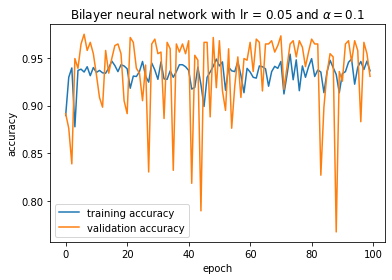

In [11]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.title(r'Bilayer neural network with lr = {} and $\alpha=${}'.format(
    sgd_learnrate, l2_alpha)
)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

In [12]:
import numpy as np

no_last = 5 # I take the last 5 due to the upwards shape of the curve at its end
print('Mean last {:d} validation accuracy : {:.3f}'.format(
    no_last, np.mean(history.history['val_accuracy'][-no_last:])
))

print('Neural network accuracy (test set): {:.3f}'.format(
    model.evaluate(X_te, to_categorical(y_te),
                   verbose=0)[1] # Loss is at index=0, accuracy at index=1
))

Mean last 5 validation accuracy : 0.938
Neural network accuracy (test set): 0.931


In [13]:
y_pred = model.predict_classes(X_te)

min(y_pred)

0

### Performance Measurement

In [14]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_te, y_pred)

array([[258,  37],
       [  4, 291]])

In [15]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
from keras.metrics import accuracy

#print('Score {:.1f}%'.format(100*accuracy_score(X_te, y_te)))
print('Area under the curve {:.1f}% - accuracy {:.1f}% - precision {:.1f}% - recall {:.1f}%'.format(100*roc_auc_score(y_te, y_pred),
                100*accuracy_score(y_te, y_pred),
                100*precision_score(y_te, y_pred),
                100*recall_score(y_te, y_pred)
               ))

Area under the curve 93.1% - accuracy 93.1% - precision 88.7% - recall 98.6%


## Results Handover

In [17]:
import results_saving_funcs as rsf

rsf.add_result_to_results(path_goldstandard, model, X_te, y_te, y_pred)

/Users/andreas/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,
